# Uplift Modeling: T-Learner and S-Learner Baseline

## Objective

This notebook implements baseline uplift modeling approaches to predict household-level treatment effects.

**What uplift modeling estimates:**
- Uplift = E[Y(1) | X] - E[Y(0) | X] where Y(1) is outcome under treatment, Y(0) under control
- T-Learner: Fits separate models for treated and control groups, then predicts uplift as difference
- S-Learner: Fits single model with treatment indicator, predicts uplift as difference between treated=1 and treated=0 predictions

**Why regression-based uplift:**
- Enables ranking households by predicted uplift for targeting
- Handles high-dimensional pre-period features
- Provides baseline for more advanced causal ML methods

**Inputs:**
- `data/intermediate/did_campaign_panel_purchase.parquet`

**Outputs:**
- Household uplift scores (CSV)
- Decile lift tables (CSV)
- Top-N household lists (CSV)
- Visualizations (PNG) in `results/modeling/uplift/figures/`
- Run manifest JSON in `results/run_manifests/`


## Imports + Logging


In [21]:
import os
import sys
import json
import logging
from pathlib import Path
from datetime import datetime, timezone
from typing import Dict, List, Optional

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

print(f"Python executable: {sys.executable}")


Python executable: /Users/rajnishpanwar/.venv/bin/python


## Repo Root + Paths


In [22]:
def find_repo_root(start: Path) -> Path:
    p = start.resolve()
    for _ in range(12):
        if (p / "README.md").exists():
            return p
        p = p.parent
    raise RuntimeError("Repository root not found (README.md missing)")

REPO_ROOT = find_repo_root(Path.cwd())
DATA_DIR = REPO_ROOT / "data" / "intermediate"
OUT_DIR = REPO_ROOT / "results" / "modeling" / "uplift"
FIG_DIR = OUT_DIR / "figures"
TABLE_DIR = OUT_DIR / "tables"
RUN_MANIFESTS_DIR = REPO_ROOT / "results" / "run_manifests"

OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)
TABLE_DIR.mkdir(parents=True, exist_ok=True)
RUN_MANIFESTS_DIR.mkdir(parents=True, exist_ok=True)

logger.info(f"Repository root: {REPO_ROOT}")


2026-01-14 18:07:13,769 - INFO - Repository root: /Users/rajnishpanwar/Desktop/Casual Analytics


## Load Panel + Validation Gates


In [23]:
panel_file = DATA_DIR / "did_campaign_panel_purchase.parquet"
if not panel_file.exists():
    raise FileNotFoundError(f"Panel file not found: {panel_file}")

df_panel = pd.read_parquet(panel_file)
logger.info(f"Loaded panel: {len(df_panel)} rows, {len(df_panel.columns)} columns")

required_cols = ["campaign_id", "household_id", "week_number", "rel_week", "treated", "post"]
missing_cols = [col for col in required_cols if col not in df_panel.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

required_outcomes = ["total_sales_value", "total_units"]
missing_outcomes = [col for col in required_outcomes if col not in df_panel.columns]
if missing_outcomes:
    raise ValueError(f"Missing required outcome columns: {missing_outcomes}")

df_panel["treated"] = pd.to_numeric(df_panel["treated"], errors="coerce").fillna(0).astype(int)
df_panel["post"] = pd.to_numeric(df_panel["post"], errors="coerce").fillna(0).astype(int)

if not df_panel["treated"].isin([0, 1]).all():
    raise ValueError("treated column must be 0 or 1")
if not df_panel["post"].isin([0, 1]).all():
    raise ValueError("post column must be 0 or 1")

logger.info("Data quality gates passed")


2026-01-14 18:07:13,784 - INFO - Loaded panel: 122536 rows, 11 columns


2026-01-14 18:07:13,789 - INFO - Data quality gates passed


## Build Household Dataset (Features/Labels) + Summary Stats


In [24]:
np.random.seed(42)

df_panel_pre = df_panel[df_panel["rel_week"] < 0].copy()
df_panel_post = df_panel[df_panel["rel_week"] >= 0].copy()

household_features = []

for hh_id in df_panel["household_id"].unique():
    pre_subset = df_panel_pre[df_panel_pre["household_id"] == hh_id]
    post_subset = df_panel_post[df_panel_post["household_id"] == hh_id]
    
    if len(pre_subset) < 2:
        continue
    
    treated_flag = df_panel[df_panel["household_id"] == hh_id]["treated"].max()
    
    pre_weeks_observed = pre_subset["week_number"].nunique()
    pre_total_sales_sum = pre_subset["total_sales_value"].sum()
    pre_total_sales_mean = pre_subset["total_sales_value"].mean()
    pre_total_units_sum = pre_subset["total_units"].sum()
    pre_total_units_mean = pre_subset["total_units"].mean()
    pre_sales_std = pre_subset["total_sales_value"].std() if len(pre_subset) > 1 else 0.0
    pre_units_std = pre_subset["total_units"].std() if len(pre_subset) > 1 else 0.0
    pre_active_weeks = (pre_subset["total_sales_value"] > 0).sum()
    
    if "total_coupon_discount" in df_panel.columns:
        pre_coupon_sum = pre_subset["total_coupon_discount"].sum()
        pre_coupon_mean = pre_subset["total_coupon_discount"].mean()
    else:
        pre_coupon_sum = 0.0
        pre_coupon_mean = 0.0
    
    post_total_sales_sum = post_subset["total_sales_value"].sum() if len(post_subset) > 0 else 0.0
    post_total_units_sum = post_subset["total_units"].sum() if len(post_subset) > 0 else 0.0
    
    delta_sales = post_total_sales_sum - pre_total_sales_sum
    
    household_features.append({
        "household_id": hh_id,
        "treated": treated_flag,
        "pre_weeks_observed": pre_weeks_observed,
        "pre_total_sales_sum": pre_total_sales_sum,
        "pre_total_sales_mean": pre_total_sales_mean,
        "pre_total_units_sum": pre_total_units_sum,
        "pre_total_units_mean": pre_total_units_mean,
        "pre_sales_std": pre_sales_std,
        "pre_units_std": pre_units_std,
        "pre_active_weeks": pre_active_weeks,
        "pre_coupon_sum": pre_coupon_sum,
        "pre_coupon_mean": pre_coupon_mean,
        "post_total_sales_sum": post_total_sales_sum,
        "post_total_units_sum": post_total_units_sum,
        "delta_sales": delta_sales
    })

df_household = pd.DataFrame(household_features)
df_household = df_household.dropna(subset=["delta_sales"])

n_households = len(df_household)
treated_count = df_household["treated"].sum()
control_count = n_households - treated_count

logger.info(f"Household dataset: {n_households} households")
logger.info(f"Treated: {treated_count}, Control: {control_count}")
logger.info(f"Treated share: {treated_count / n_households:.2%}")

if control_count < 5:
    logger.warning(f"Very few control households ({control_count}). Uplift estimates may be unstable.")


2026-01-14 18:07:13,841 - INFO - Household dataset: 30 households
2026-01-14 18:07:13,841 - INFO - Treated: 15, Control: 15
2026-01-14 18:07:13,842 - INFO - Treated share: 50.00%


## Train T-Learner + Results


In [25]:
feature_cols = [
    "pre_weeks_observed", "pre_total_sales_sum", "pre_total_sales_mean",
    "pre_total_units_sum", "pre_total_units_mean", "pre_sales_std",
    "pre_units_std", "pre_active_weeks", "pre_coupon_sum", "pre_coupon_mean"
]

X_all = df_household[feature_cols].fillna(0)
y_all = df_household["delta_sales"].values

df_treated = df_household[df_household["treated"] == 1].copy()
df_control = df_household[df_household["treated"] == 0].copy()

X_treated = df_treated[feature_cols].fillna(0)
y_treated = df_treated["delta_sales"].values

X_control = df_control[feature_cols].fillna(0)
y_control = df_control["delta_sales"].values

model_t = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, min_samples_split=5)
model_c = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, min_samples_split=5)

if len(X_treated) > 0:
    model_t.fit(X_treated, y_treated)
    pred_t = model_t.predict(X_all)
else:
    pred_t = np.zeros(len(X_all))

if len(X_control) > 0:
    model_c.fit(X_control, y_control)
    pred_c = model_c.predict(X_all)
else:
    pred_c = np.zeros(len(X_all))

uplift_t_learner = pred_t - pred_c

df_household["uplift_score_t_learner"] = uplift_t_learner

logger.info(f"T-Learner fitted. Treated model: {len(X_treated)} samples, Control model: {len(X_control)} samples")


2026-01-14 18:07:13,922 - INFO - T-Learner fitted. Treated model: 15 samples, Control model: 15 samples


## Train S-Learner + Results


In [26]:
X_s_all = df_household[feature_cols + ["treated"]].fillna(0)
y_s_all = df_household["delta_sales"].values

model_s = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, min_samples_split=5)
model_s.fit(X_s_all, y_s_all)

X_treated_flag = X_all.copy()
X_treated_flag["treated"] = 1
pred_s_treated = model_s.predict(X_treated_flag)

X_control_flag = X_all.copy()
X_control_flag["treated"] = 0
pred_s_control = model_s.predict(X_control_flag)

uplift_s_learner = pred_s_treated - pred_s_control

df_household["uplift_score_s_learner"] = uplift_s_learner

logger.info(f"S-Learner fitted on {len(X_s_all)} samples")


2026-01-14 18:07:13,967 - INFO - S-Learner fitted on 30 samples


## Uplift Diagnostics (Deciles, Curve) + Plots


In [27]:
df_household["uplift_decile_t"] = pd.qcut(df_household["uplift_score_t_learner"], q=10, labels=False, duplicates='drop')
df_household["uplift_decile_s"] = pd.qcut(df_household["uplift_score_s_learner"], q=10, labels=False, duplicates='drop')

deciles_t = df_household.groupby("uplift_decile_t").agg({
    "delta_sales": "mean",
    "treated": ["count", "sum"],
    "uplift_score_t_learner": "mean"
}).reset_index()
deciles_t.columns = ["decile", "mean_delta_sales", "n_households", "n_treated", "mean_uplift_score"]
deciles_t["n_control"] = deciles_t["n_households"] - deciles_t["n_treated"]
deciles_t.to_csv(TABLE_DIR / "uplift_deciles_t_learner.csv", index=False)

deciles_s = df_household.groupby("uplift_decile_s").agg({
    "delta_sales": "mean",
    "treated": ["count", "sum"],
    "uplift_score_s_learner": "mean"
}).reset_index()
deciles_s.columns = ["decile", "mean_delta_sales", "n_households", "n_treated", "mean_uplift_score"]
deciles_s["n_control"] = deciles_s["n_households"] - deciles_s["n_treated"]
deciles_s.to_csv(TABLE_DIR / "uplift_deciles_s_learner.csv", index=False)

logger.info("Decile tables computed and saved")


2026-01-14 18:07:13,982 - INFO - Decile tables computed and saved


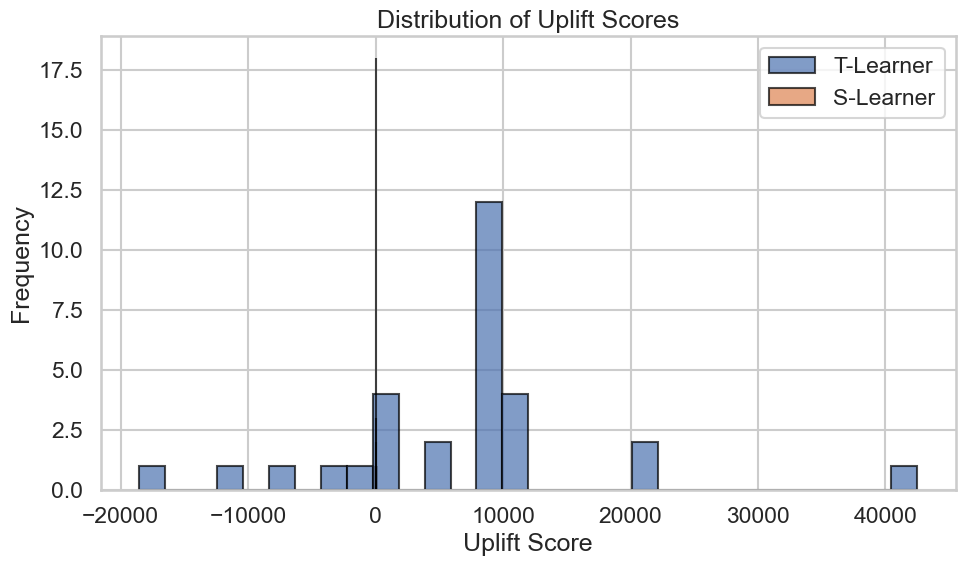

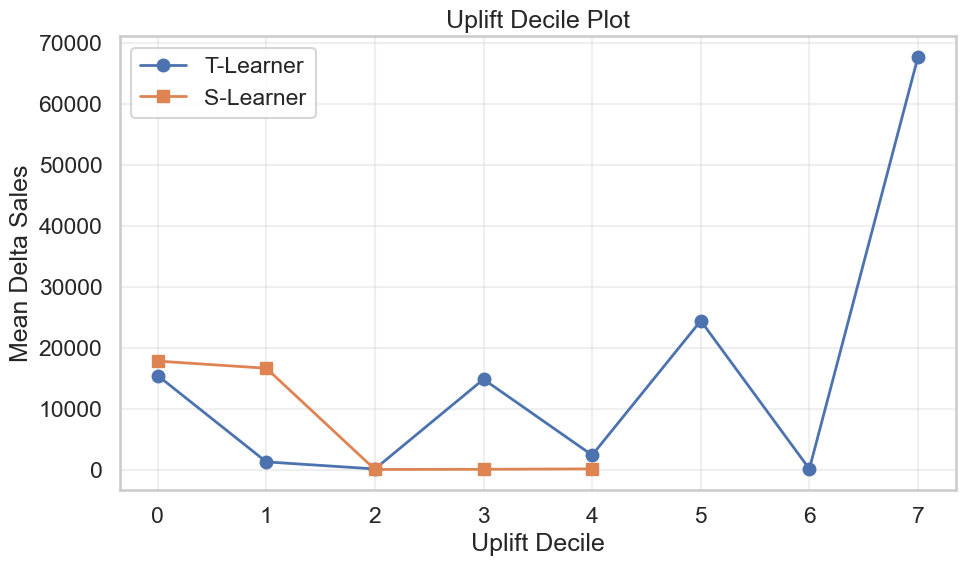

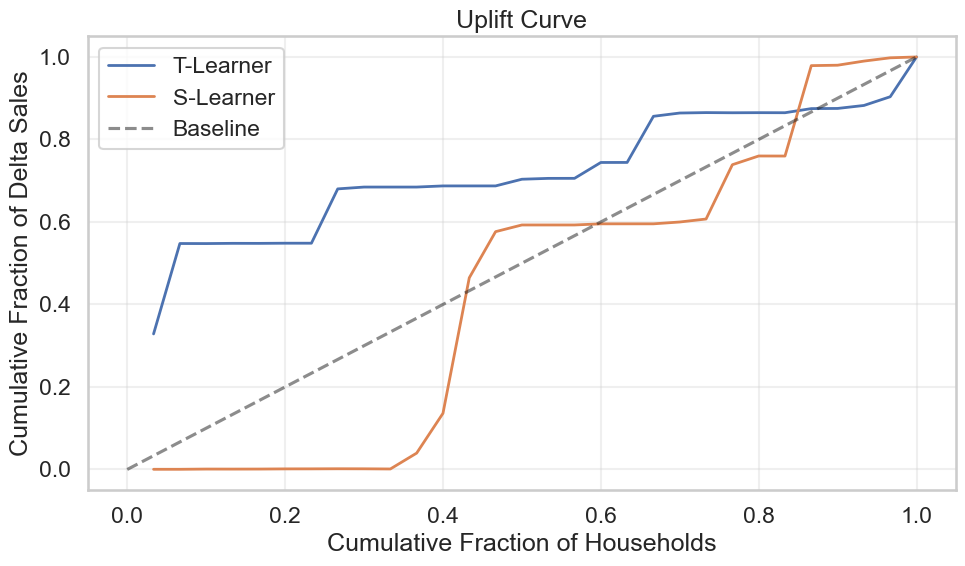

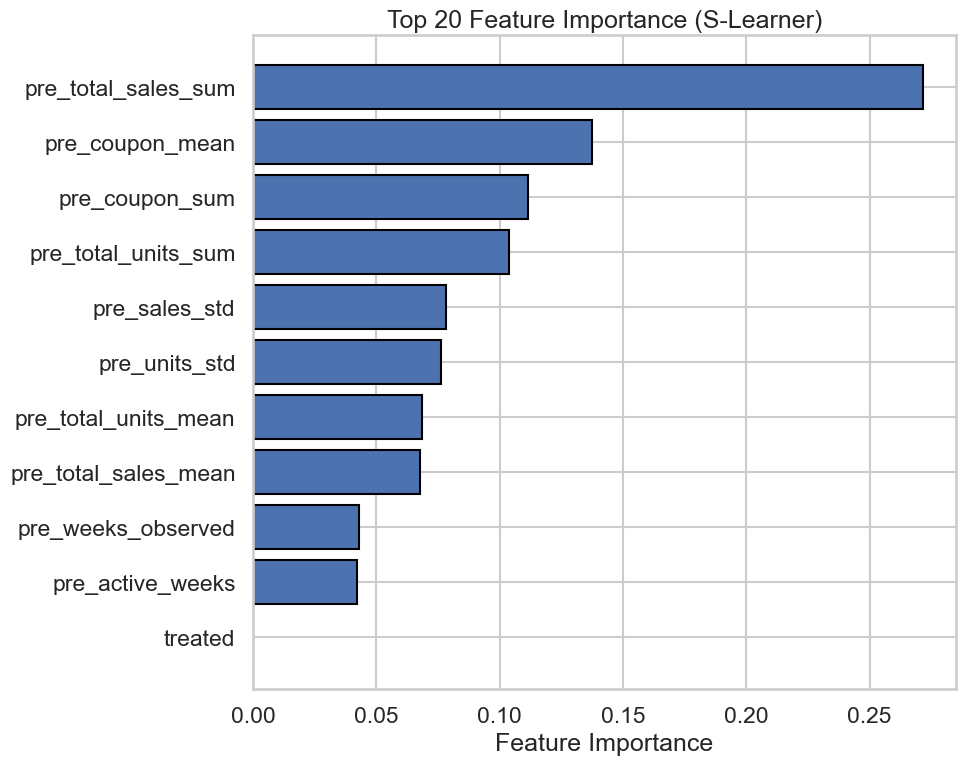

2026-01-14 18:07:14,558 - INFO - Feature importance plot saved


In [28]:
%matplotlib inline
sns.set_theme(style="whitegrid", context="talk")

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(uplift_t_learner, bins=30, alpha=0.7, label='T-Learner', edgecolor='black')
ax.hist(uplift_s_learner, bins=30, alpha=0.7, label='S-Learner', edgecolor='black')
ax.set_xlabel("Uplift Score")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Uplift Scores")
ax.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "uplift_score_distribution.png", dpi=150, bbox_inches='tight')
plt.show()
plt.close()

fig, ax = plt.subplots(figsize=(10, 6))
deciles_t_sorted = deciles_t.sort_values("decile")
ax.plot(deciles_t_sorted["decile"], deciles_t_sorted["mean_delta_sales"], marker='o', label='T-Learner', linewidth=2)
deciles_s_sorted = deciles_s.sort_values("decile")
ax.plot(deciles_s_sorted["decile"], deciles_s_sorted["mean_delta_sales"], marker='s', label='S-Learner', linewidth=2)
ax.set_xlabel("Uplift Decile")
ax.set_ylabel("Mean Delta Sales")
ax.set_title("Uplift Decile Plot")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "uplift_decile_plot.png", dpi=150, bbox_inches='tight')
plt.show()
plt.close()

df_household_sorted_t = df_household.sort_values("uplift_score_t_learner", ascending=False)
df_household_sorted_t["cumulative_households"] = np.arange(1, len(df_household_sorted_t) + 1) / len(df_household_sorted_t)
df_household_sorted_t["cumulative_delta_sales"] = df_household_sorted_t["delta_sales"].cumsum() / df_household_sorted_t["delta_sales"].sum()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_household_sorted_t["cumulative_households"], df_household_sorted_t["cumulative_delta_sales"], linewidth=2, label='T-Learner')
df_household_sorted_s = df_household.sort_values("uplift_score_s_learner", ascending=False)
df_household_sorted_s["cumulative_households"] = np.arange(1, len(df_household_sorted_s) + 1) / len(df_household_sorted_s)
df_household_sorted_s["cumulative_delta_sales"] = df_household_sorted_s["delta_sales"].cumsum() / df_household_sorted_s["delta_sales"].sum()
ax.plot(df_household_sorted_s["cumulative_households"], df_household_sorted_s["cumulative_delta_sales"], linewidth=2, label='S-Learner')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Baseline')
ax.set_xlabel("Cumulative Fraction of Households")
ax.set_ylabel("Cumulative Fraction of Delta Sales")
ax.set_title("Uplift Curve")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "uplift_curve.png", dpi=150, bbox_inches='tight')
plt.show()
plt.close()

try:
    if hasattr(model_s, 'feature_importances_'):
        feature_imp = pd.DataFrame({
            'feature': feature_cols + ['treated'],
            'importance': model_s.feature_importances_
        }).sort_values('importance', ascending=False).head(20)
        
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.barh(range(len(feature_imp)), feature_imp['importance'], edgecolor='black')
        ax.set_yticks(range(len(feature_imp)))
        ax.set_yticklabels(feature_imp['feature'])
        ax.set_xlabel("Feature Importance")
        ax.set_title("Top 20 Feature Importance (S-Learner)")
        ax.invert_yaxis()
        plt.tight_layout()
        plt.savefig(FIG_DIR / "feature_importance_top20.png", dpi=150, bbox_inches='tight')
        plt.show()
        plt.close()
        logger.info("Feature importance plot saved")
except Exception as e:
    logger.warning(f"Could not generate feature importance plot: {e}")


## Save Outputs


In [29]:
output_cols = [
    "household_id", "treated", "pre_total_sales_sum", "post_total_sales_sum",
    "delta_sales", "uplift_score_t_learner", "uplift_score_s_learner",
    "uplift_decile_t", "uplift_decile_s"
]
df_household[output_cols].to_csv(TABLE_DIR / "household_uplift_scores.csv", index=False)

df_household_top_t = df_household.nlargest(50, "uplift_score_t_learner")[output_cols]
df_household_top_t.to_csv(TABLE_DIR / "top_50_households_by_uplift_t.csv", index=False)

df_household_top_s = df_household.nlargest(50, "uplift_score_s_learner")[output_cols]
df_household_top_s.to_csv(TABLE_DIR / "top_50_households_by_uplift_s.csv", index=False)

logger.info(f"Saved outputs to {TABLE_DIR}")


2026-01-14 18:07:14,569 - INFO - Saved outputs to /Users/rajnishpanwar/Desktop/Casual Analytics/results/modeling/uplift/tables


## Run Manifest


In [30]:
def get_package_versions() -> Dict[str, str]:
    versions = {}
    for pkg in ["pandas", "numpy", "sklearn", "matplotlib", "seaborn"]:
        try:
            mod = __import__(pkg)
            versions[pkg] = getattr(mod, "__version__", "unknown")
        except ImportError:
            versions[pkg] = "not_installed"
    return versions

timestamp_utc = datetime.now(timezone.utc).isoformat()

output_files = [
    str(TABLE_DIR.relative_to(REPO_ROOT) / "household_uplift_scores.csv"),
    str(TABLE_DIR.relative_to(REPO_ROOT) / "uplift_deciles_t_learner.csv"),
    str(TABLE_DIR.relative_to(REPO_ROOT) / "uplift_deciles_s_learner.csv"),
    str(TABLE_DIR.relative_to(REPO_ROOT) / "top_50_households_by_uplift_t.csv"),
    str(TABLE_DIR.relative_to(REPO_ROOT) / "top_50_households_by_uplift_s.csv"),
    str(FIG_DIR.relative_to(REPO_ROOT) / "uplift_score_distribution.png"),
    str(FIG_DIR.relative_to(REPO_ROOT) / "uplift_decile_plot.png"),
    str(FIG_DIR.relative_to(REPO_ROOT) / "uplift_curve.png")
]

if (FIG_DIR / "feature_importance_top20.png").exists():
    output_files.append(str(FIG_DIR.relative_to(REPO_ROOT) / "feature_importance_top20.png"))

manifest = {
    "timestamp_utc": timestamp_utc,
    "python_executable": str(sys.executable),
    "package_versions": get_package_versions(),
    "input_file": str(panel_file.relative_to(REPO_ROOT)),
    "output_files": output_files,
    "dataset_stats": {
        "n_households": int(n_households),
        "treated_count": int(treated_count),
        "control_count": int(control_count),
        "pre_week_min": float(df_household["pre_weeks_observed"].min()),
        "pre_week_median": float(df_household["pre_weeks_observed"].median())
    },
    "model_configs": {
        "t_learner": {
            "model_type": "RandomForestRegressor",
            "n_estimators": 100,
            "max_depth": 5,
            "random_state": 42
        },
        "s_learner": {
            "model_type": "RandomForestRegressor",
            "n_estimators": 100,
            "max_depth": 5,
            "random_state": 42
        }
    }
}

manifest_file = RUN_MANIFESTS_DIR / f"uplift_manifest_{datetime.now(timezone.utc).strftime('%Y%m%d_%H%M%S')}.json"
with open(manifest_file, 'w') as f:
    json.dump(manifest, f, indent=2)

logger.info(f"Run manifest saved to {manifest_file}")


2026-01-14 18:07:14,576 - INFO - Run manifest saved to /Users/rajnishpanwar/Desktop/Casual Analytics/results/run_manifests/uplift_manifest_20260114_180714.json


## Next Steps

This baseline uplift modeling provides household-level treatment effect predictions using T-Learner and S-Learner approaches.

**How this feeds targeting:**
- Rank households by predicted uplift scores
- Target top deciles with highest predicted uplift
- Use decile tables to estimate expected lift by segment

**Future improvements:**
- Consider more advanced methods (X-Learner, causal forests)
- Add interaction terms and non-linear features
- Cross-validation for model selection
- Sensitivity analysis for treatment assignment assumptions
